<a href="https://colab.research.google.com/github/Nisarg38/ExploringQAtechniques-BERTandGPT/blob/main/LlamaBaseTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dataclasses accelerate typing transformers datasets tqdm json5 bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26308 sha256=593109550e3790ca3572992d52b38bda1b3d26402c1a4a0eafd3cf93d12ef9bd
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built typing


In [ ]:
import csv
import json
import logging
from dataclasses import dataclass, field
from typing import Optional
import torch
import transformers
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
import logging
import json5
from datasets import load_dataset
from tqdm import tqdm
from transformers import HfArgumentParser

In [ ]:
# Function to get prompt messages
def get_prompt(message: str, chat_history: list[tuple[str, str]],
               system_prompt: str) -> str:
    texts = [f"<s>[INST] <<SYS>>\n{system_prompt}\n<</SYS>>\n\n"]
    # The first user input is _not_ stripped
    do_strip = False
    for user_input, response in chat_history:
        user_input = user_input.strip() if do_strip else user_input
        do_strip = True
        texts.append(f"{user_input} [/INST] {response.strip()} </s><s>[INST] ")
    message = message.strip() if do_strip else message
    texts.append(f"{message} [/INST]")
    return "".join(texts)

In [ ]:
SYSTEM_PROMPT = """\
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.
If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\
"""

In [ ]:
@dataclass
class ScriptArguments:
    prompt: Optional[str] = field(
        default="single_turn",
        metadata={"help": "single_turn, multi_turn"},
    )
    dataset: Optional[str] = field(
        default="data/squad_v2",
    )

In [ ]:
# Manually specify the arguments as a list
#args_list = ["--prompt", "multi_turn", "--train_dataset", "data/train-v2.0.json", "--val_dataset", "data/dev-v2.0.json"]
parser = HfArgumentParser(ScriptArguments)
script_args = parser.parse_args_into_dataclasses(return_remaining_strings=True)[0]

In [ ]:
logger = logging.getLogger()
transformers.logging.set_verbosity_error()

In [ ]:
def get_single_turn_prompt_and_response(item, all_answers=False):
    context = item["context"]
    question = item["question"]
    answers = item["answers"]["text"]
    if len(answers) == 0:
        answers = ["I don't know"]
    answers = json.dumps(answers) if all_answers else f'"{answers[0]}"'

    return {
        "text": get_prompt(
            f"""\
Extract from the following context the minimal span word for word that best answers the question. Think step by step and explain your reasoning. Then give the answer in JSON format as follows:
```json
{{
  "answer": ...
}}
```
If the answer is not in the context, the answer should be "I don't know".
Context: {context}
Question: {question}""",
            [],
            SYSTEM_PROMPT,
        )
        + f""" \
```json
{{
  "answer": {answers}
}}
``` </s>"""
    }


In [ ]:
def get_multi_turn_prompt_and_response(item, all_answers=False):
    context = item["context"]
    question = item["question"]
    answers = item["answers"]["text"]
    if len(answers) == 0:
        answers = ["I don't know"]
    answers = json.dumps(answers) if all_answers else f'"{answers[0]}"'

    return {
        "text": get_prompt(
            """\
Now give the answer in JSON format as follows:
```json
{
  "answer": ...
}
```
If the answer is not in the context, the answer should be "I don't know".
""",
            [
                (
                    f"""\
Use the following context to answer the question. Think step by step and explain your reasoning.
Context: {context}
Question: {question}""",
                    "",
                ),
                (
                    f"""\
Extract the minimal span word for word from the context that best answers the question.
        """,
                    "",
                ),
            ],
            SYSTEM_PROMPT,
        )
        + f""" \
```json
{{
  "answer": {answers}
}}
``` </s>"""
    }


In [ ]:
instruction = {
    "single_turn": get_single_turn_prompt_and_response,
    "multi_turn": get_multi_turn_prompt_and_response,
}[script_args.prompt]

In [ ]:
squad_dataset = load_dataset("squad_v2")
test_dataset = squad_dataset["validation"].map(
    instruction, fn_kwargs={"all_answers": True}
)
print(test_dataset[0]["text"])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.
If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

Extract from the following context the minimal span word for word that best answers the question. Think step by step and explain your reasoning. Then give the answer in JSON format as follows:
```json
{
  "answer": ...
}
```
If the answer is not in the context, the answer should be "I don't know".
Context: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region 

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
""" config parameters"""
# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)
print(compute_dtype)

torch.float16


In [ ]:
device_map = {"":0}

In [ ]:
model_name="meta-llama/Llama-2-7b-chat-hf"
#load model
model = AutoModelForCausalLM.from_pretrained(
    model_name, quantization_config=bnb_config,
    device_map=device_map)
model.config.use_cache = False
model.config.pretraining_tp = 1
# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

In [ ]:
def extract_answer(text):
    text = text[text.find("{") :]
    text = text[: text.find("}") + 1]
    try:
        # JSON5 is a little less picky than JSON
        answer = json5.loads(text)["answer"]
    except:
        answer = None
    return answer

In [ ]:
def get_answer(prompt, pipeline):
    response = ""
    while True:
        instruction = prompt.find("[/INST] ")
        if instruction == -1:
            break
        instruction += len("[/INST] ")
        current_prompt = response.strip()
        current_prompt += prompt[:instruction] + "</s>"
        logger.debug("Instruction: %s", prompt[:instruction])
        prompt = prompt[instruction:]
        prompt = prompt[prompt.find("<s>") :]
        response = pipeline(
            current_prompt,
            do_sample=False,
            num_beams=1,
            num_return_sequences=1,
            max_new_tokens=512,
        )[0]["generated_text"]
        logger.debug("Response: %s", response[len(current_prompt) :].strip())

    response = response[len(current_prompt) :].strip()
    return extract_answer(response), response

In [ ]:
%mkdir results

In [ ]:
sample_data = test_dataset.select(range(500))

In [ ]:
from difflib import SequenceMatcher
def similar(a, b):
    """Calculate the similarity between two strings"""
    sm = SequenceMatcher(None, a, b).ratio()
    return sm

In [ ]:

with open("results/Llamaresults.csv", "w", encoding='utf-8', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(
        [
            "Context",
            "Question",
            "Correct answers",
            "Model answer",
            "Full response",
            "exact_match",
            "Micro-F1"
        ]
    )

    dataset = sample_data
    shuffle = False
    if shuffle:
        dataset = dataset.shuffle()

    for text in tqdm(dataset["text"]):
        answer_start = text.rfind("```json")
        prompt = text[:answer_start]
        answers = extract_answer(text[answer_start:])
        context = prompt[prompt.find("Context: ") + 9 : prompt.find("Question: ") - 1]
        context = context.encode("utf-8").decode("utf-8", "ignore")
        logger.debug("Context: %s", context)
        question = prompt[prompt.find("Question: ") + 10 : prompt.find("[/INST] ")]
        question = question[: question.find("[/INST]")]
        logger.debug("Question: %s", question)
        logger.debug("Correct answers: %s", answers)
        model_answer, full_response = get_answer(prompt, pipeline)
        logger.debug("Model answer: %s", model_answer)
        exact_match = model_answer is not None and model_answer in answers
        acc = []
        for answer in answers:
          model_answer = str(model_answer)
          similarity = similar(answer, model_answer)
          acc.append(similarity)

        accuracy = sum(acc)/len(acc)

        writer.writerow(
            [
                context,
                question,
                json.dumps(answers),
                model_answer,
                full_response,
                exact_match,
                accuracy
            ]
        )
        file.flush()

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 500/500 [1:07:35<00:00,  8.11s/it]


Contents in csv file:       exact_match  Micro-F1
0           True  1.000000
1          False  0.582329
2          False  0.692308
3           True  1.000000
4          False  0.245058
..           ...       ...
495         True  1.000000
496         True  1.000000
497        False  0.216216
498         True  1.000000
499        False  0.857143

[500 rows x 2 columns]


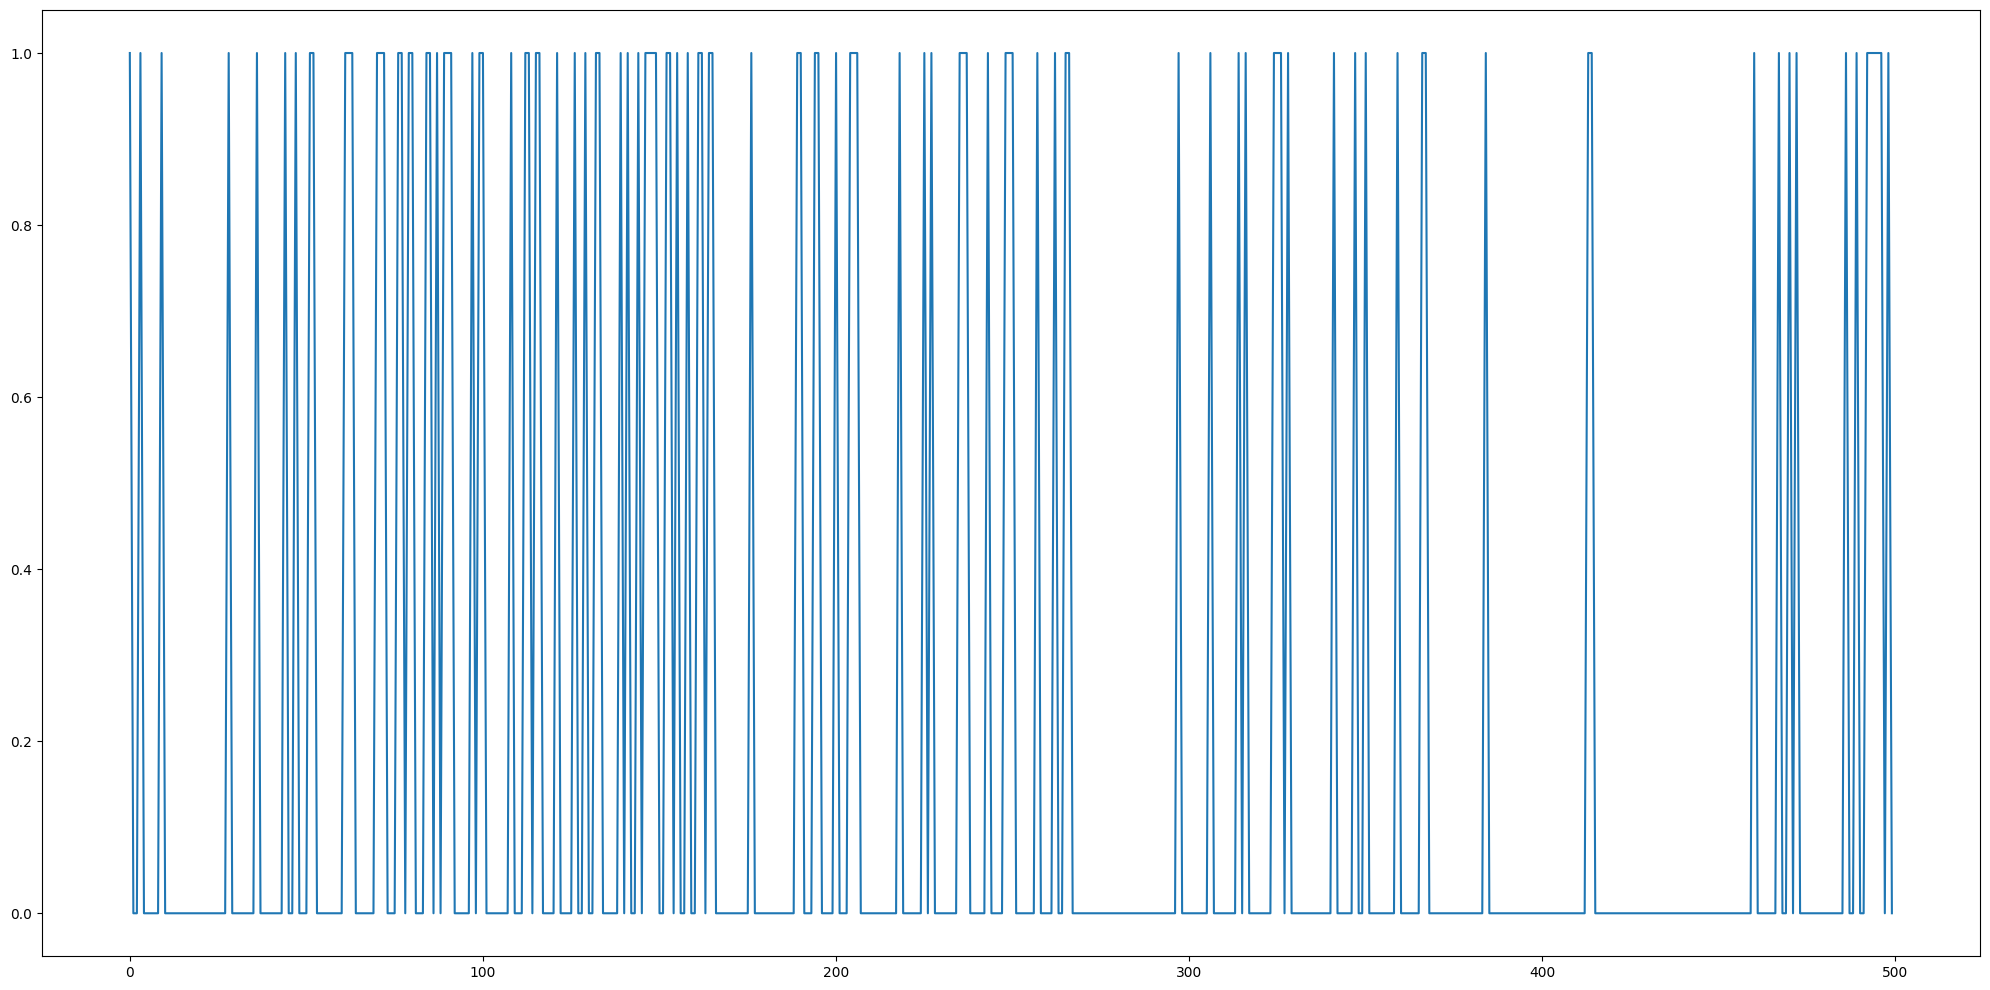

Mean of Exact_match:  0.21
std:  0.40771615730782573


<Figure size 2000x1000 with 0 Axes>

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
columns = ["exact_match", "Micro-F1"]
df = pd.read_csv("results/Llamaresults.csv", usecols=columns)
df.columns.str.replace(' ','_')
print("Contents in csv file: ", df)
plt.plot(df.exact_match)
plt.show()
plt.savefig("results/results_llama_EM.png")
EM = df.exact_match.mean()
std = df.exact_match.std()
print("Mean of Exact_match: ", EM)
print("std: " , std)

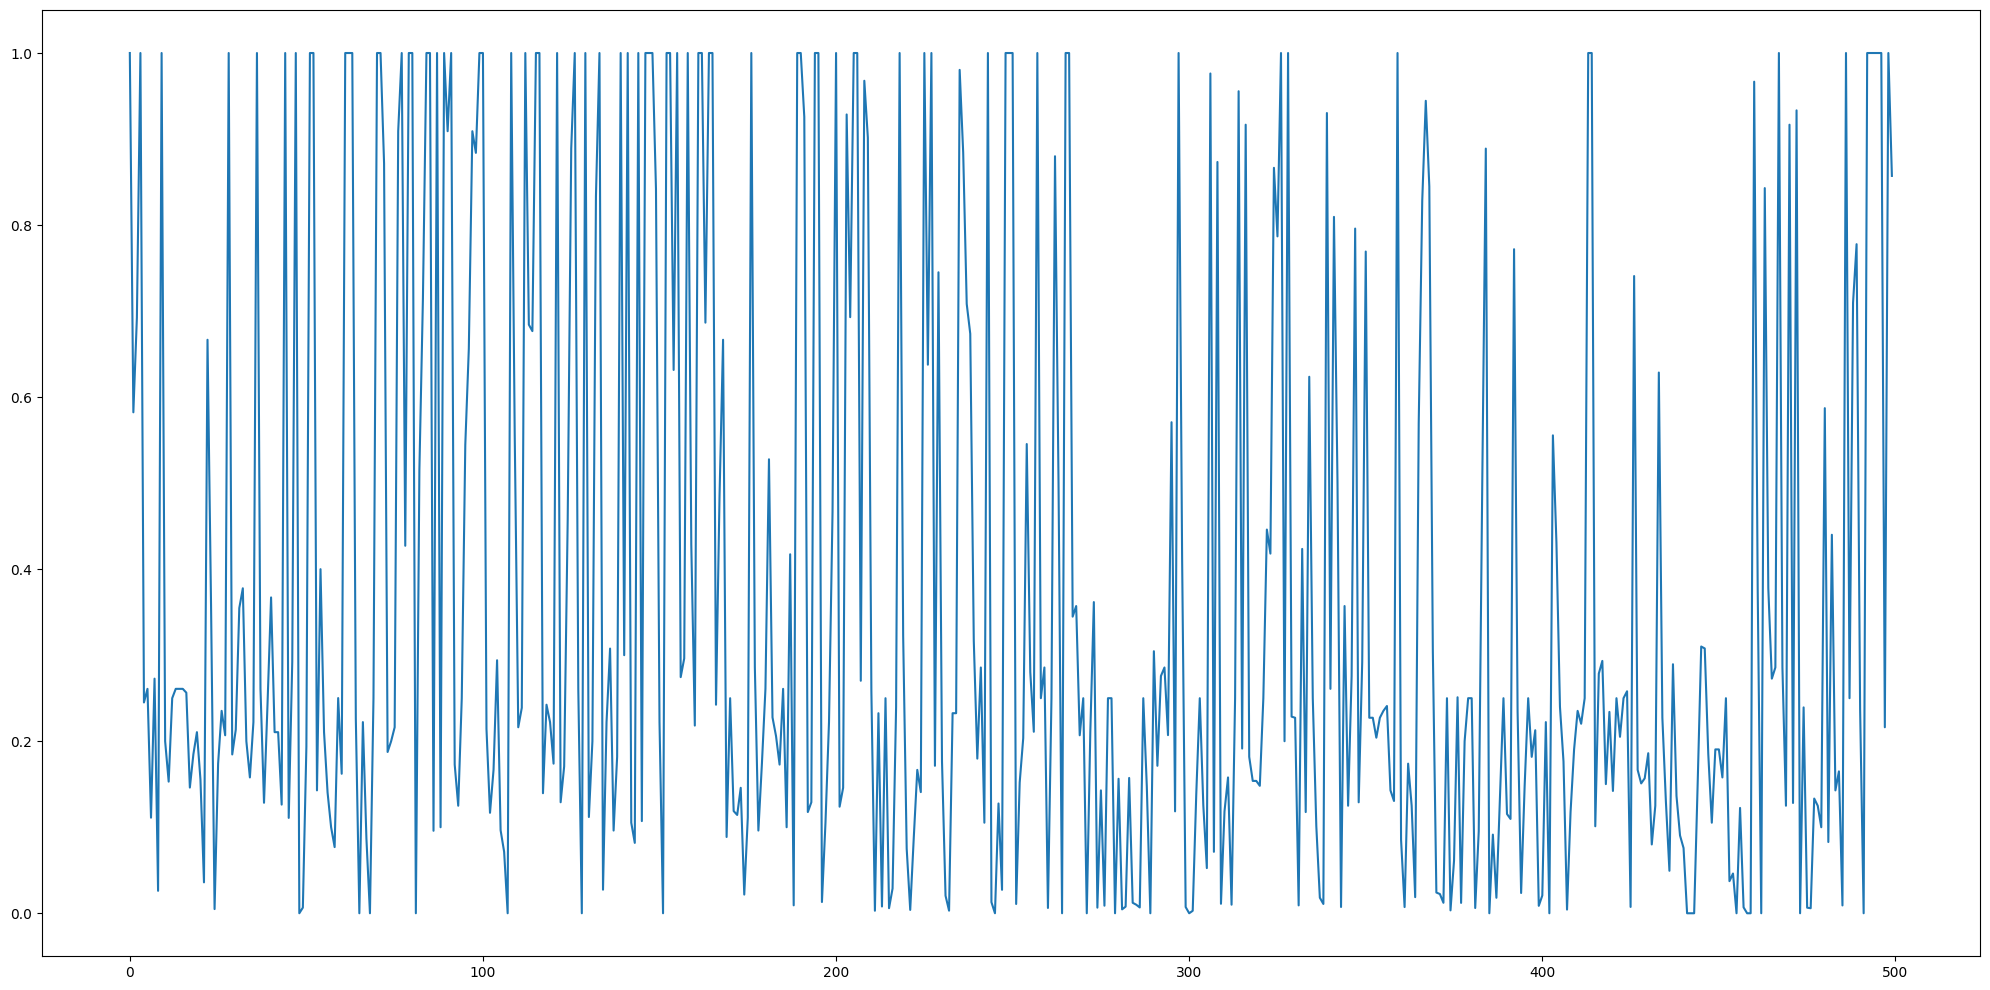

0.37446887484890085
0.3531932189774709


<Figure size 2000x1000 with 0 Axes>

In [ ]:
df.rename(columns={'Micro-F1': 'accuracy'}, inplace=True)
plt.plot(df.accuracy)
plt.show()
plt.savefig("results/results_llama_accuracy.png")
Acc = df.accuracy.mean()
print(Acc)
std = df.accuracy.std()
print(std)